In [1]:
!apt-get install -y xvfb python-opengl > /dev/null 2>&1

In [ ]:
!pip install gym pyvirtualdisplay > /dev/null 2>&1

In [ ]:
 !sudo apt update

Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran35/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Get:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release [564 B]
Get:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release.gpg [833 B]
Get:7 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran35/ Packages [95.7 kB]
Hit:8 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:9 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease [21.3 kB]
Get:11 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Packages [47.5 kB]
Get:12 http://security.ubuntu.com/ubuntu bionic-security InRele

In [ ]:
!sudo apt-get install xvfb

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-440
Use 'sudo apt autoremove' to remove it.
The following additional packages will be installed:
  xserver-common
Recommended packages:
  xfonts-base
The following NEW packages will be installed:
  xvfb
The following packages will be upgraded:
  xserver-common
1 upgraded, 1 newly installed, 0 to remove and 76 not upgraded.
Need to get 810 kB of archives.
After this operation, 2,266 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 xserver-common all 2:1.19.6-1ubuntu4.6 [26.9 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 xvfb amd64 2:1.19.6-1ubuntu4.6 [783 kB]
Fetched 810 kB in 1s (609 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based front

In [ ]:
!pip3 install box2d-py

     |████████████████████████████████| 450kB 4.1MB/s 


In [ ]:
# Landing pad is always at coordinates (0,0). Coordinates are the first
# two numbers in state vector. Reward for moving from the top of the screen
# to landing pad and zero speed is about 100..140 points. If lander moves
# away from landing pad it loses reward back. Episode finishes if the lander
# crashes or comes to rest, receiving additional -100 or +100 points.
# Each leg ground contact is +10. Firing main engine is -0.3 points each frame.
# Solved is 200 points. Landing outside landing pad is possible. Fuel is
# infinite, so an agent can learn to fly and then land on its first attempt.
# Four discrete actions available: do nothing, fire left orientation engine,
# fire main engine, fire right orientation engine.


import gym
import random
from keras import Sequential
from collections import deque
from keras.layers import Dense
from keras.optimizers import Adam
import matplotlib.pyplot as plt
from keras.activations import relu, linear
from IPython import display as ipythondisplay

In [ ]:
from pyvirtualdisplay import Display
display = Display(visible=0, size=(400, 300))
display.start()

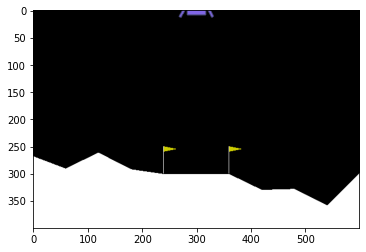

In [ ]:
import numpy as np
env = gym.make('LunarLander-v2')
env.seed(0) #generating random numbers for the environment
env.reset() #reset to start the environment, ususlly use this function at the start or end of an episode
prev_screen = env.render(mode='rgb_array')
plt.imshow(prev_screen) #capture the screen
np.random.seed(0)

In [ ]:
class DQN:

    """ Implementation of deep q learning algorithm """

    def __init__(self, action_space, state_space):

        self.action_space = action_space
        self.state_space = state_space
        self.epsilon = 1.0     #at the start of the training process,we will only choose the action based on the highest value
        self.gamma = .99       #discount value, in this case,future rewards are nearly as important as the current rewards
        self.batch_size = 64   #setting batch size for experience replay
        self.epsilon_min = .01 
        self.lr = 0.001        #learning rate for adam optimizer
        self.epsilon_decay = .996   #for expolration after training a certain period
        self.memory = deque(maxlen=1000000) #creating queue for saving states actions pairs
        self.model = self.build_model()  #building model

    def build_model(self):
        model = Sequential()  #linear stack of layers,
        #input layer with state spaces connected with dese layer and activation function relu
        model.add(Dense(150, input_dim=self.state_space, activation=relu)) 
        model.add(Dense(120, activation=relu))    #regular deeply connected neural network layer
        model.add(Dense(self.action_space, activation=linear)) #output layer,we use linear activation not to discard values. A = cx
        #MSE is the sum of squared distances between our target variable and predicted values. 
        #Adam is a stochastic gradient descent method that computes individual adaptive learning rates for different parameters 
        #from estimates of first- and second-order moments of the gradients
        model.compile(loss='mse', optimizer=Adam(lr=self.lr))
        return model

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done)) #saving 

    def act(self, state):

        if np.random.rand() <= self.epsilon:              #for random exploration 
            return random.randrange(self.action_space)    
        act_values = self.model.predict(state)            #getting sets of predited actions
        return np.argmax(act_values[0])                   #exploitation based on model

    """ experience replay for better DQN model""" 
    def replay(self):

        if len(self.memory) < self.batch_size:            #we just save every set until the number of sets reach to batch size
            return
        #take random sets from memory
        minibatch = random.sample(self.memory, self.batch_size)
        states = np.array([i[0] for i in minibatch])       #return states with the shape (64,1,8)
        actions = np.array([i[1] for i in minibatch])      #return actions with the shape (64,)
        rewards = np.array([i[2] for i in minibatch])      #return rewards with the shape (64,)
        next_states = np.array([i[3] for i in minibatch])  #return next_states with the shape (64,1,8)
        dones = np.array([i[4] for i in minibatch])        #return priorities with the shape (64,)

        states = np.squeeze(states)                        #reduce the dimension to (64,8) for future calculations         
        next_states = np.squeeze(next_states)              #reduce the dimension to (64,8) for future calculations

        targets = rewards + self.gamma*(np.amax(self.model.predict_on_batch(next_states), axis=1))*(1-dones) #calculate target
        targets_full = self.model.predict_on_batch(states)                                                   #model predicted target
        ind = np.array([i for i in range(self.batch_size)]) #create (64,) array to use as index
        targets_full[[ind], [actions]] = targets            #save target values for each action for the batches with shape(64,4)

        self.model.fit(states, targets_full, epochs=1, verbose=0) #train model,restart training after 1 epoch,without showing progression
        if self.epsilon > self.epsilon_min:                #change epsilon to start exploration 
            self.epsilon *= self.epsilon_decay             



In [ ]:
def train_dqn(episode):
  loss = []                 #save loss value
  agent = DQN(env.action_space.n, env.observation_space.shape[0])
  for e in range(episode):
    state = env.reset() #reset to start the environment, ususlly use this function at the start or end of an episode
    state = np.reshape(state, (1, 8)) #reshape the states to be compatable with future calculations
    score = 0                         #to save the scores for each episode
    max_steps = 3000
    for i in range(max_steps):
      action = agent.act(state)       #get actions based on trained model
      screen = env.render(mode='rgb_array') #for rendering the environment
      plt.imshow(screen)
      ipythondisplay.clear_output(wait=True)
      ipythondisplay.display(plt.gcf())
      next_state, reward, done, _ = env.step(action) #control env according to the action come from model and get returns from env
      score += reward                                #update scores
      next_state = np.reshape(next_state, (1, 8))    #reshape the next states to be compatable with future calculations
      agent.remember(state, action, reward, next_state, done) #save to memory
      state = next_state
      agent.replay()                                 #train the model with the experience replay
      if done:
        print("episode: {}/{}, score: {}".format(e, episode, score)) 
        break

    loss.append(score)                               #save score for each episode

    # Average score of last 100 episode
    is_solved = np.mean(loss[-100:])
    if is_solved > 200:
      print('\n Task Completed! \n')
      break
    print("Average over last 100 episode: {0:.2f} \n".format(is_solved))
    print(loss)
  return loss

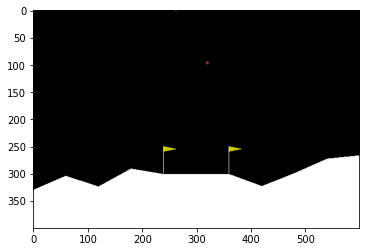

In [ ]:

if __name__ == '__main__':
    episodes = 400
    loss = train_dqn(episodes)
    plt.plot([i+1 for i in range(0, len(loss), 2)], loss[::2])    #plotting scores 
    plt.show()              